In [5]:
# Importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import metrics

from gp_qsar import GPytorch_qsar
from gp_qsar.utils import splitter

### Model building with censored data

Often data from biological assays is censored within a measurement range e.g. <4 or <8.5

Below is an example of artifically censored data. We can use gpytorch_qsar to build a model properly accounting for the survival type loss in censored data - inspired by likelihoods from arXiv:2402.11973 [cs.LG]

Gpytorch takes SMILES, target and censored vector arguments. The censored vectors are np.ndarrays containing -1 for left censored values, 1 for right censored vlaues, and 0 for uncensored values. The objective function for uncensored values is minimising the negative marginal log likelihood.

In [13]:
# Load and Process Data
file = "../data/raw/JNK1_data.csv"
JNK1_df = pd.read_csv(file, sep=";")
JNK1_df = JNK1_df.loc[(JNK1_df["Standard Relation"] == "'='")*(JNK1_df["Standard Units"] == "nM")]
JNK1_df = JNK1_df.drop_duplicates(subset="Smiles").dropna(subset="Standard Value")
JNK1_df["pIC50"] = -np.log10(JNK1_df["Standard Value"]*1e-9).to_numpy()

# Artificially test censored data
JNK1_df["pIC50_uncensored"] = JNK1_df["pIC50"]
JNK1_df["pIC50"] = JNK1_df["pIC50"].apply(lambda x: ">8.5" if x > 8.5 else ("<4.0" if x < 4.0 else x))

JNK1_df.to_csv("../data/processed/JNK1_censored.csv")

train_smiles, test_smiles, train_y, test_y = splitter(JNK1_df["Smiles"], JNK1_df["pIC50"], method="scaffold", test_size=0.25)
_,_, train_y_uncensored, test_y_uncensored = splitter(JNK1_df["Smiles"], JNK1_df["pIC50_uncensored"], method="scaffold", test_size=0.25)

# Generate Censored vectors
censored_train = np.where(train_y == "<4.0", -1, np.where(train_y == ">8.5", 1, 0))
censored_test = np.where(test_y == "<4.0", -1, np.where(test_y == ">8.5", 1, 0))

# # Covert to float
train_y = np.where(train_y == ">8.5", 8.5, train_y)
train_y = np.where(train_y == "<4.0", 4., train_y).astype(float)

test_y = np.where(test_y == ">8.5", 8.5, test_y)
test_y = np.where(test_y == "<4.0", 4., test_y).astype(float)

In [10]:
# build and tune model

model = GPytorch_qsar(train_smiles, train_y, censored_train)
model.fit_tune_model(n_trials=100, n_splits=5)

[I 2024-11-13 16:22:31,163] A new study created in memory with name: no-name-b893b06b-8a6d-4c6e-953e-e814e763920b
[I 2024-11-13 16:22:34,502] Trial 0 finished with value: 1.7633212327957153 and parameters: {'features': 'FCFP', 'kernel': 'RBF', 'lengthscale': 7.10991852018085, 'noise': 0.002068243584637287, 'n_iter': 195, 'lr': 0.08324593965363418}. Best is trial 0 with value: 1.7633212327957153.
[I 2024-11-13 16:22:36,215] Trial 1 finished with value: 2.2348265171051027 and parameters: {'features': 'FCFP,Physchem', 'kernel': 'RBF', 'lengthscale': 2.99223202049866, 'noise': 0.03664252071093624, 'n_iter': 97, 'lr': 0.07851974437968744}. Best is trial 0 with value: 1.7633212327957153.
[I 2024-11-13 16:22:37,358] Trial 2 finished with value: inf and parameters: {'features': 'FCFP,Physchem', 'kernel': 'Tanimoto', 'noise': 0.08084165083816496, 'n_iter': 68, 'lr': 0.009776234679498324}. Best is trial 0 with value: 1.7633212327957153.
[I 2024-11-13 16:22:39,058] Trial 3 finished with value: 2.

Best parameters: {'features': 'ECFP,Physchem', 'kernel': 'Tanimoto', 'noise': 0.014326074492304816, 'n_iter': 198, 'lr': 0.09970253875436888}
Best score: 1.5595457077026367


/home/cwoodley/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


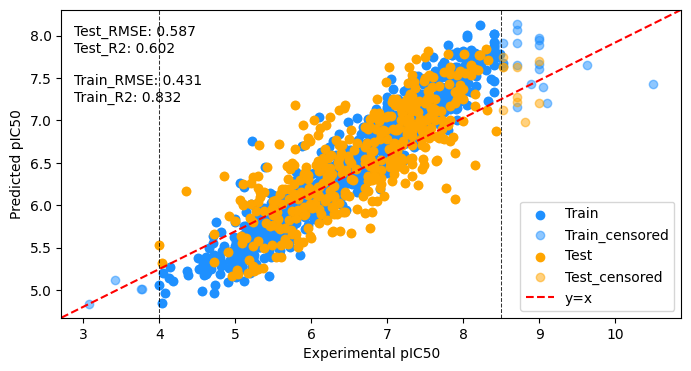

In [22]:

train_pred = model.predict_from_smiles(train_smiles)
test_pred, test_std = model.predict_from_smiles(test_smiles, uncert=True)

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.scatter(train_y[censored_train == 0], train_pred[censored_train == 0], label="Train",color="dodgerblue")
ax.scatter(train_y_uncensored, train_pred, label="Train_censored", alpha=0.5, color="dodgerblue")

ax.scatter(test_y[censored_test == 0], test_pred[censored_test == 0], label="Test", color="orange")
ax.scatter(test_y_uncensored, test_pred, label="Test_censored", alpha=0.5, color="orange")

xlims = ax.get_xlim()
ylims = ax.get_ylim()

ax.plot([xlims[0],xlims[1]], [ylims[0],ylims[1]], linestyle="--", color="red", label = "y=x")
ax.set_xlim(xlims)
ax.set_ylim(ylims)


te_rmse = np.sqrt(metrics.mean_squared_error(test_y_uncensored, test_pred))
te_r2 = metrics.r2_score(test_y_uncensored, test_pred)
tr_rmse = np.sqrt(metrics.mean_squared_error(train_y_uncensored, train_pred))
tr_r2 = metrics.r2_score(train_y_uncensored, train_pred)

ax.text(0.02, 0.95, f"Test_RMSE: {te_rmse:.3f}\nTest_R2: {te_r2:.3f}\n\nTrain_RMSE: {tr_rmse:.3f}\nTrain_R2: {tr_r2:.3f}", transform=ax.transAxes, verticalalignment="top")
ax.set_ylabel("Predicted pIC50")
ax.set_xlabel("Experimental pIC50")
ax.legend(loc="lower right")

ax.axvline(4.0, color="black", linewidth=0.75, alpha=0.8, linestyle = "--", label="Threshold")
ax.axvline(8.5, color="black", linewidth=0.75, alpha=0.8, linestyle = "--")